## **Summary**

The dataset for this project was collected from kaggle and originates from from Nasdaq Financials. fundamentals.csv contains New York Stock Exchange historical metrics extracted from annual SEC 10K fillings (2012-2016), should be enough to derive most of popular fundamental indicators.

In this project, we will focus on clustering and apply unsupervised learning techniques to find the best candidate algorithm that accurately predicts wether a company has net profit or net loss. To do that, we will transform Net Income column into a binary representation of whether or not a company made profit, where 0 represents loss and 1 represents profit.

Why do we use net income?

Net income indicates a company's profit after all of its expenses have been deducted from revenues. This number appears on a company's income statement and is also an indicator of a company's profitability.



## **Exploratory Data Analysis**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, DBSCAN
from scipy.cluster import hierarchy

# Mute the sklearn and IPython warnings
import warnings
warnings.filterwarnings('ignore', module='sklearn')
warnings.filterwarnings('ignore', module='python')
pd.options.display.float_format = '{:.2f}'.format

In [2]:
data = pd.read_csv('./fundamentals.csv')
data.head()

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3068000000.00,-222000000.00,-1961000000.00,23.00,-1888000000.00,4695000000.00,53.00,...,7072000000.00,9011000000.00,-7987000000.00,24891000000.00,16904000000.00,24855000000.00,-367000000.00,2012.00,-5.60,335000000.00
1,1,AAL,2013-12-31,4975000000.00,-93000000.00,-2723000000.00,67.00,-3114000000.00,10592000000.00,75.00,...,14323000000.00,13806000000.00,-2731000000.00,45009000000.00,42278000000.00,26743000000.00,0.00,2013.00,-11.25,163022222.22
2,2,AAL,2014-12-31,4668000000.00,-160000000.00,-150000000.00,143.00,-5311000000.00,15135000000.00,60.00,...,11750000000.00,13404000000.00,2021000000.00,41204000000.00,43225000000.00,42650000000.00,0.00,2014.00,4.02,716915422.89
3,3,AAL,2015-12-31,5102000000.00,352000000.00,-708000000.00,135.00,-6151000000.00,11591000000.00,51.00,...,9985000000.00,13605000000.00,5635000000.00,42780000000.00,48415000000.00,40990000000.00,0.00,2015.00,11.39,668129938.54
4,4,AAP,2012-12-29,2409453000.00,-89482000.00,600000.00,32.00,-271182000.00,520215000.00,23.00,...,3184200000.00,2559638000.00,1210694000.00,3403120000.00,4613814000.00,6205003000.00,-27095000.00,2012.00,5.29,73283553.88


In [3]:
data.shape

(1781, 79)

In [4]:
data.isnull().sum()

Unnamed: 0                        0
Ticker Symbol                     0
Period Ending                     0
Accounts Payable                  0
Accounts Receivable               0
                               ... 
Total Revenue                     0
Treasury Stock                    0
For Year                        173
Earnings Per Share              219
Estimated Shares Outstanding    219
Length: 79, dtype: int64

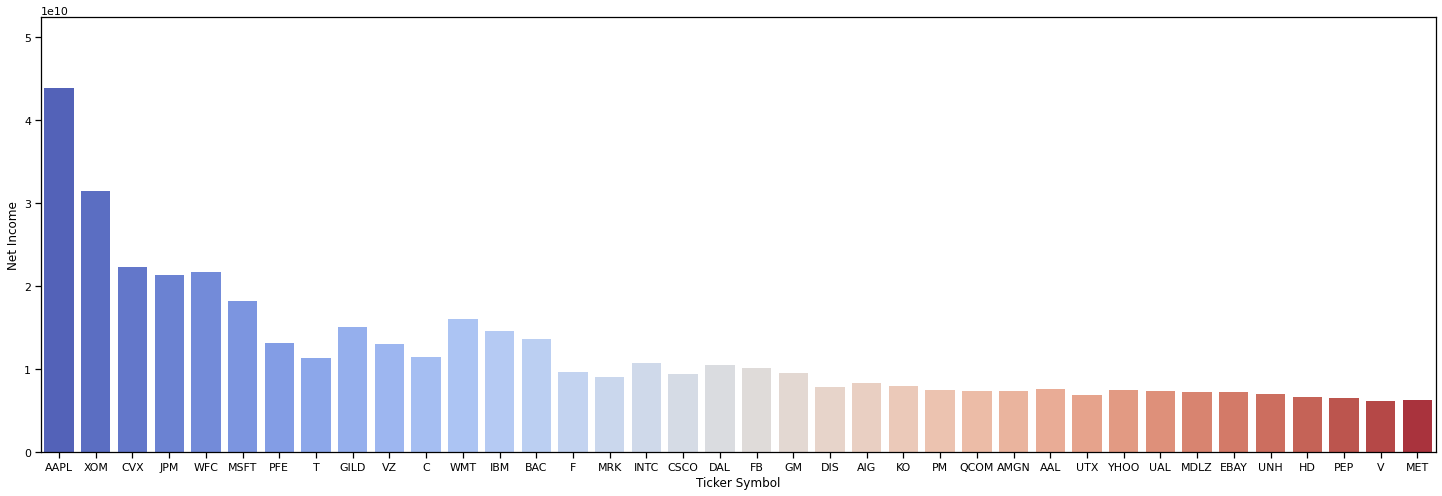

In [5]:
plt.figure(figsize=(25, 8))
sub_data = data.sort_values(by='Net Income', ascending=False).head(100)

sns.set_context('notebook')
sns.barplot(x=sub_data['Ticker Symbol'], y=data['Net Income'], palette='coolwarm', errwidth=0)

## **Feature Transformation**



*   Drop **Unnamed: 0**, **Ticker Symbol** and **Period Ending** column as they don't carry any information.
*   Drop columns with missing values.
*   Make sure all the columns are continuous which is what we need for K-means clustering.
*   Transform Net Income into a binary column
*   Ensure the data is scaled and normally distributed





In [6]:
data.drop(['Unnamed: 0', 'Ticker Symbol', 'Period Ending'],axis = 1, inplace=True)
data.dropna(axis=1,inplace=True)

In [7]:
data.isnull().sum().all() == 0

True

In [8]:
data.dtypes.all() == 'float64'

False

In [9]:
data['Net Income'] = data['Net Income'].apply(lambda x : 1 if x > 0 else 0)

In [10]:
data['Net Income'].value_counts()

1    1679
0     102
Name: Net Income, dtype: int64

In [11]:
log_columns = data.skew().sort_values(ascending=False)
log_columns = log_columns.loc[log_columns > 0.75]

log_columns

Pre-Tax ROE                                           18.00
After Tax ROE                                         15.98
Other Operating Activities                            15.83
Minority Interest                                     15.77
Equity Earnings/Loss Unconsolidated Subsidiary        14.91
Accounts Receivable                                   14.46
Common Stocks                                         12.15
Short-Term Debt / Current Portion of Long-Term Debt   11.88
Non-Recurring Items                                   11.80
Long-Term Debt                                        11.36
Interest Expense                                      11.28
Other Liabilities                                     11.07
Short-Term Investments                                10.87
Cash and Cash Equivalents                             10.11
Intangible Assets                                     10.03
Add'l income/expense items                             9.98
Other Current Liabilities               

In [12]:
for col in log_columns.index:
    data[col] = np.log1p(data[col])

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
data.dropna(axis=1,inplace=True)

In [14]:
sc = StandardScaler()
feature_columns = [x for x in data.columns if x not in 'Net Income']
for col in feature_columns:
    data[col] = sc.fit_transform(data[[col]])

data.head(4)

,Accounts Payable,After Tax ROE,Capital Expenditures,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,Cost of Revenue,Deferred Asset Charges,Deferred Liability Charges,Effect of Exchange Rate,...,Sale and Purchase of Stock,Short-Term Debt / Current Portion of Long-Term Debt,Short-Term Investments,Total Assets,Total Current Assets,Total Current Liabilities,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock
0,0.35,0.30,-0.21,0.24,0.17,0.53,0.42,-0.84,0.58,0.24,...,0.28,0.68,1.48,0.26,0.52,0.60,0.61,0.01,0.84,0.25
1,0.48,1.39,-0.63,0.51,0.17,-0.11,0.43,-0.84,0.73,0.24,...,0.28,0.68,1.57,0.70,0.60,0.65,1.00,0.70,0.90,0.28
2,0.47,2.17,-1.36,0.40,0.17,-0.04,0.49,-0.84,0.71,0.24,...,-0.10,0.70,1.54,0.71,0.58,0.65,0.94,0.71,1.28,0.28
3,0.49,2.11,-1.64,0.13,0.17,-0.07,0.43,1.41,0.69,0.24,...,-1.12,0.74,1.54,0.80,0.56,0.65,0.97,0.80,1.25,0.28


## **Train Models**



*   Fit a K-means clustering model with two clusters and
*   Fit 2 Agglomerative clustering models with two clusters (ward-link and complete-link clustering)
*   Compare the results to those obtained by K-means with regards to wine color by reporting the number of red and white observations in each cluster for both K-means and agglomerative clustering.
*   Visualize the dendrogram produced by agglomerative clustering







### **K-Means**

In [15]:
km = KMeans(n_clusters=2, random_state=62)
km = km.fit(data[feature_columns])

data['kmeans'] = km.predict(data[feature_columns])
(data[['Net Income','kmeans']]
 .groupby(['kmeans','Net Income'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))

number
kmeans Net Income        
0      0                8
       1              295
1      0               94
       1             1384

### **Agglomerative Clustering**

In [16]:
for linkage in ['complete', 'ward']:
    ag = AgglomerativeClustering(n_clusters=2, linkage=linkage, compute_full_tree=True)
    ag = ag.fit(data[feature_columns])
    data[str('agglom_'+linkage)] = ag.fit_predict(data[feature_columns])

In [17]:
(data[['Net Income','agglom_ward']]
 .groupby(['Net Income','agglom_ward'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))

number
Net Income agglom_ward        
0          0                13
           1                89
1          0               323
           1              1356

In [18]:
(data[['Net Income','agglom_complete']]
     .groupby(['Net Income','agglom_complete'])
     .size()
     .to_frame()
     .rename(columns={0:'number'}))

number
Net Income agglom_complete        
0          0                   102
1          0                  1671
           1                     8

In [19]:
(data[['Net Income','agglom_complete', 'agglom_ward','kmeans']]
 .groupby(['Net Income', 'agglom_complete', 'agglom_ward', 'kmeans'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))


number
Net Income agglom_complete agglom_ward kmeans        
0          0               0           0            8
                                       1            5
                           1           1           89
1          0               0           0          287
                                       1           28
                           1           1         1356
           1               0           0            8

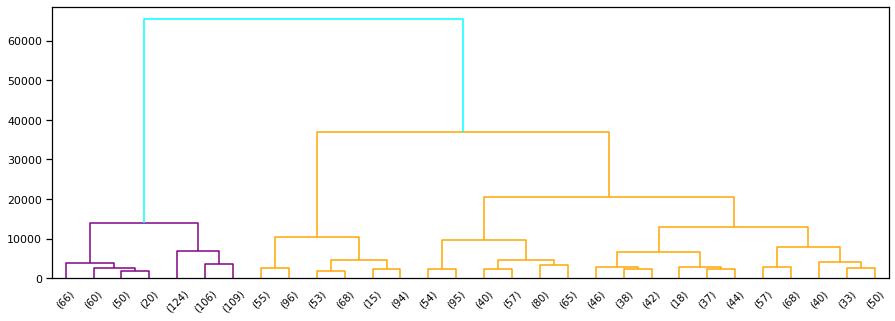

In [20]:
Z = hierarchy.linkage(ag.children_, method='ward')

fig, ax = plt.subplots(figsize=(15,5))


hierarchy.set_link_color_palette(['purple', 'orange'])

den = hierarchy.dendrogram(Z, orientation='top', 
                           p=30, truncate_mode='lastp',
                           show_leaf_counts=True, ax=ax,
                           above_threshold_color='cyan')

# **Results**

Comparing the results shows that I am able to predict profit better than loss which is what I expected given that we have more data for companies with profit(1: 1679 vs 0: 102). The best algorithm for predicting loss is the Complete-link Agglomerative Clustering model and for predicting profit KMeans Clustering seems to be the best candidate althought Ward-link Agglomerative Clustering achieved nearly the same result.

Better result could be achieved by performing PCA or hyperparameter tuning.